In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Harmful Algae Blooms in Bolinao (from HABhub) - Sheet1.csv")
print(df.shape)
print(df.info())
df.head()

(1929, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station_name      1929 non-null   object 
 1   embayment         1929 non-null   object 
 2   longitude         1929 non-null   float64
 3   latitude          1929 non-null   float64
 4   sample_date       1929 non-null   object 
 5   dissolved oxygen  1929 non-null   float64
 6   ph                1929 non-null   float64
 7   water temp        1929 non-null   float64
 8   time              1929 non-null   object 
 9   chlorophyll-a     1929 non-null   float64
dtypes: float64(6), object(4)
memory usage: 150.8+ KB
None


,station_name,embayment,longitude,latitude,sample_date,dissolved oxygen,ph,water temp,time,chlorophyll-a
0,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.5200,7.5755,28.8045,0:01:00,2.6136
1,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.0384,7.5566,28.7676,1:01:00,2.4442
2,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
3,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.1008,7.5566,28.7575,3:01:00,2.2264
4,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9424,7.6007,28.8213,4:01:00,2.4079


### Split
Let us split the data first to prevent any leakage

In [117]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [118]:
df_train.nunique()

station_name           1
embayment              1
longitude              1
latitude               1
sample_date           92
dissolved oxygen     868
ph                   244
water temp          1480
time                  24
chlorophyll-a        689
dtype: int64

In [119]:
cont_vars = df_train.nunique() != 1
filtered_df = df_train[df_train.columns[cont_vars]]
filtered_df = filtered_df.rename(columns={"chlorophyll-a": "chl", 
                                         "dissolved oxygen": "dissolved_oxygen",
                                         "water temp": "water_temp"})
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,time,chl
1352,2022-10-12,-2.6848,6.9140,30.6774,6:01:00,4.6948
141,2022-08-17,0.3344,7.5692,29.8578,2:01:00,3.4848
2,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
1190,2022-10-01,-0.7552,6.8762,30.2540,10:01:00,2.9645
1803,2023-10-02,1.1163,-0.2700,32.4355,15:01:00,1.6214
...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,22:01:00,2.9282
1294,2022-10-07,0.2960,6.8825,31.8933,19:01:00,7.3689
860,2022-09-17,-1.2544,6.8069,30.6729,13:01:00,4.5980
1459,2022-10-18,-2.6992,6.7754,29.7998,0:01:00,1.6335


In [120]:
filtered_df['sample_date'] = pd.to_datetime(filtered_df["sample_date"])
filtered_df['sample_date_int'] = filtered_df['sample_date'].astype("int64") / 10**11

filtered_df['time_hour'] = pd.to_datetime(filtered_df['time'], format="%H:%M:%S").dt.hour
filtered_df.drop(columns="time", inplace=True)

##### Note

* Converted `sample_date` to datetime format
* Added `sample_date_int` as a int varsion of the `sample_date` column
* Added `time_hour` to get only the Hour in time
* Removed the `time` column

Let us first do a simple Multiple Linear Regression to get a glimpse of everything

In [121]:
from statsmodels.formula.api import ols

formula = "chl ~ " + " + ".join([col for col in filtered_df.drop(columns="sample_date").columns  if col != "chl"])
lmlm = ols(formula, data=filtered_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     103.2
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           5.07e-94
Time:                        23:25:35   Log-Likelihood:                -4385.5
No. Observations:                1543   AIC:                             8783.
Df Residuals:                    1537   BIC:                             8815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          718.6260     94.972      7.567      0.000     532.337     904.915
dissolved_oxygen     0.0799      0.036      2.226      0.026       0.009       0.150
ph                  -1.4007      0.278     -5.047      0.000      -1.945      -0.856
water_temp           1.9163      0.106     18.070      0.000       1.708       2.124
sample_date_int  -4.583e-05    5.6e-06     -8.184      0.000   -5.68e-05   -3.48e-05
time_hour            0.0729      0.016      4.573      0.000       0.042       0.104
==============================================================================
Omnibus:                     1067.235   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17136.045
Skew:                           3.060   Prob(JB):                         0.00
Kurtosis:                      18.135   Cond. No.                     1.49e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All are significant except the `dissolved_oxygen` which could be problematic given that we need that column!

In [122]:
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
1352,2022-10-12,-2.6848,6.9140,30.6774,4.6948,16655328.0,6
141,2022-08-17,0.3344,7.5692,29.8578,3.4848,16606944.0,2
2,2022-08-11,-0.9472,7.5881,28.7926,2.6257,16601760.0,2
1190,2022-10-01,-0.7552,6.8762,30.2540,2.9645,16645824.0,10
1803,2023-10-02,1.1163,-0.2700,32.4355,1.6214,16962048.0,15
...,...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,2.9282,16643232.0,22
1294,2022-10-07,0.2960,6.8825,31.8933,7.3689,16651008.0,19
860,2022-09-17,-1.2544,6.8069,30.6729,4.5980,16633728.0,13
1459,2022-10-18,-2.6992,6.7754,29.7998,1.6335,16660512.0,0


### EDA

#### Missing Values

In [123]:
filtered_df.isna().sum()

sample_date         0
dissolved_oxygen    0
ph                  0
water_temp          0
chl                 0
sample_date_int     0
time_hour           0
dtype: int64

#### Distribution

Text(0.5, 1.0, 'Distribution of Columns')

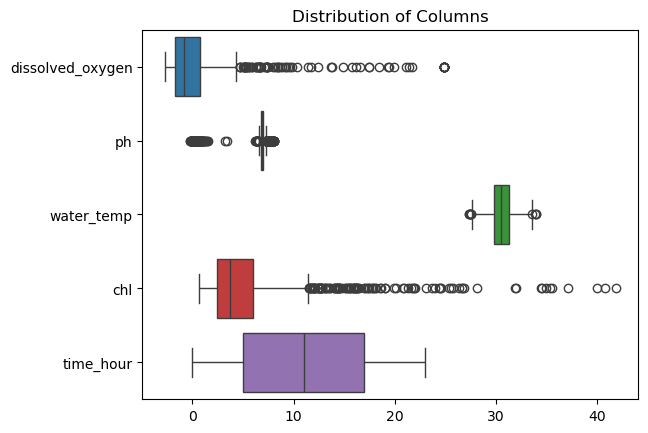

In [124]:
sns.boxplot(filtered_df.drop(columns=["sample_date", 'sample_date_int']), orient="h")
plt.title("Distribution of Columns")

Lots of outliers in all of columns with exception of `time_hour`

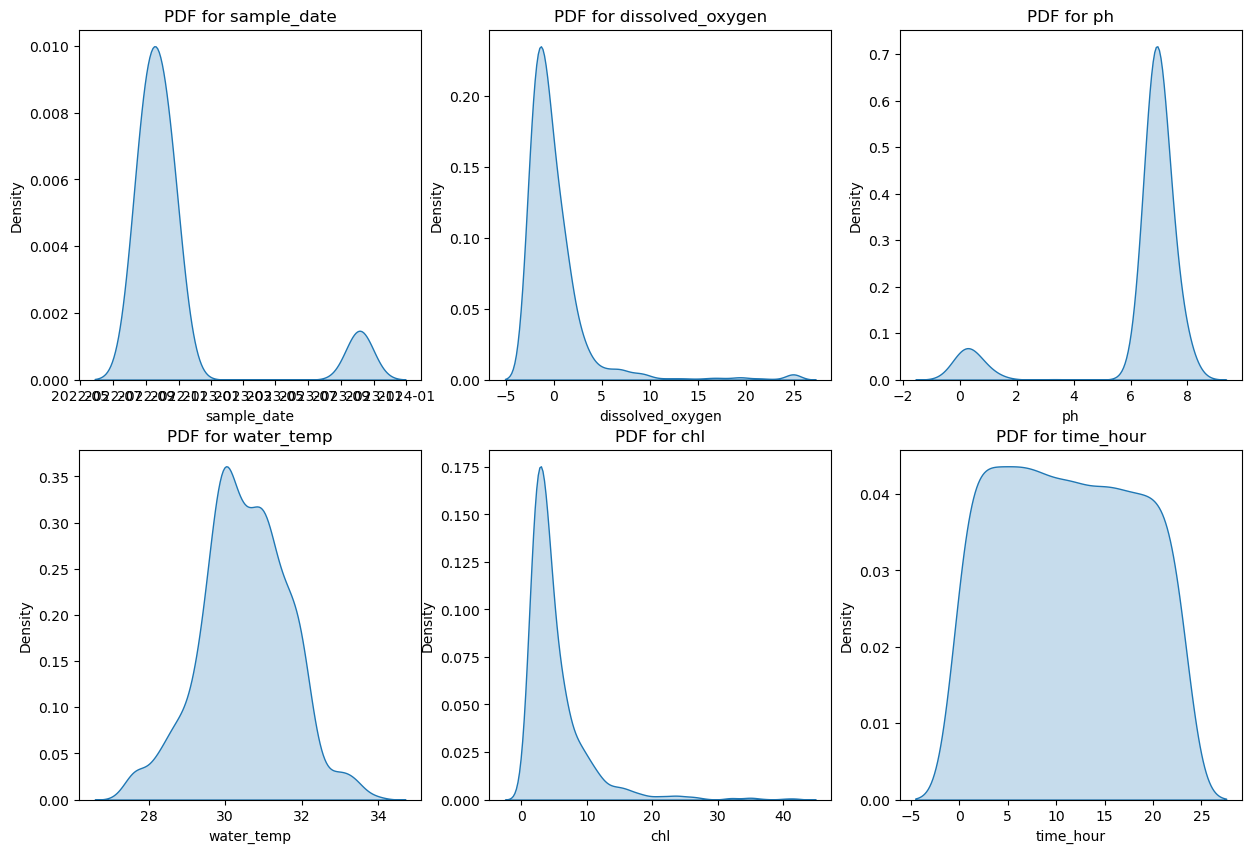

In [110]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = filtered_df.drop(columns=['sample_date_int']).columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(filtered_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col}")

Well it appears that all of our columns are skewed! With the exceptions of `water_temp` and `time_hour`.

This isn't usually an issue in a linear regression model but given that we also got significant amount of outliers for each of those skewed data, a transformation is in order. With transformation, we can reduce the outliers and normalize the data which is beneficial for our linear model.

Let's look at the range before proceeding.

In [116]:
filtered_df.aggregate(["min", "max"])

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
min,2022-08-11,-2.6992,-0.2700,27.3432,0.6413,16601760.0,0
max,2023-10-16,24.8880,8.0606,33.9583,41.8297,16974144.0,23


So we can't do log transformation because `dissolved_oxygen` and `ph` has negative values.

Let's try "Yeo-Jhonson" since it can handle negative values.

In [139]:
filtered_df_fix = filtered_df.drop(columns=['sample_date_int', 'sample_date'])

In [151]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")

pt.fit(filtered_df_fix)

new_data = pt.transform(filtered_df_fix)

new_df = pd.DataFrame(new_data, columns=cols)

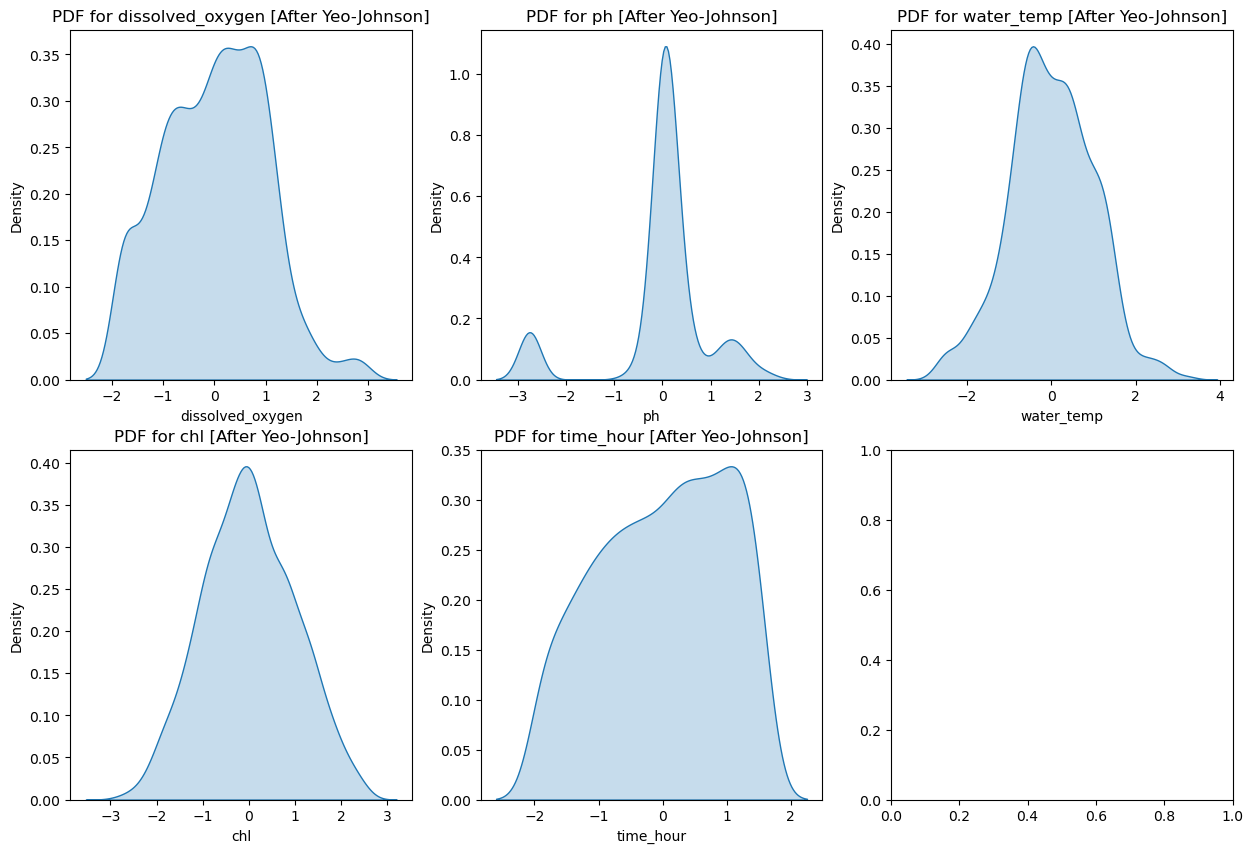

In [152]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = new_df.columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(new_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col} [After Yeo-Johnson]")

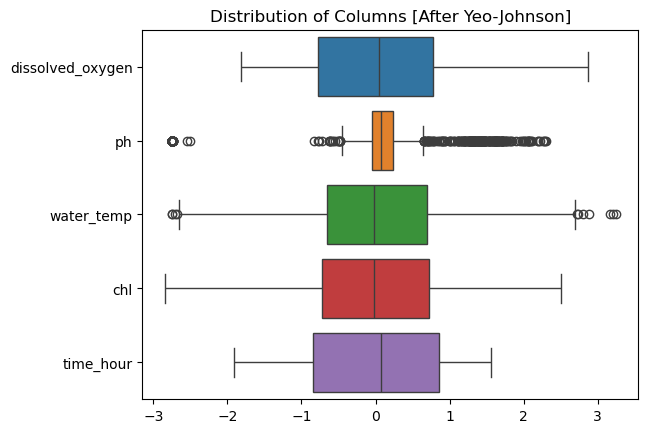

In [150]:
sns.boxplot(new_df, orient="h")
plt.title("Distribution of Columns [After Yeo-Johnson]");

There we go! Not only Yeo-Johnson makes the distribution Normal but it also lessen the outliers! 

But there's still some work to do for there are still outliers.

Our focus now shall be the `water_temp` and `ph`.

And how to mitigate them effects.

In [174]:
def detect_outliers(data, mult=1.5, normalized=True):
    '''Count the outliers using iqr'''
    lower, upper = data.quantile([0.25,0.75])

    iqr = upper - lower

    lower_bound, upper_bound = lower - iqr*mult, upper + iqr*mult

    outliers = len(data) - (data.between(lower_bound, upper_bound)).sum()
    if not normalized:
        return outliers
    else:
        return outliers / len(data)

In [175]:
new_df.apply(detect_outliers, axis=0) 

dissolved_oxygen    0.000000
ph                  0.235904
water_temp          0.007129
chl                 0.000000
time_hour           0.000000
dtype: float64

In [177]:
formula = "chl ~ " + " + ".join([col for col in new_df.columns  if col != "chl"])
lmlm = ols(formula, data=new_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     163.5
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          1.06e-116
Time:                        00:34:14   Log-Likelihood:                -1916.1
No. Observations:                1543   AIC:                             3842.
Df Residuals:                    1538   BIC:                             3869.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -8.674e-17      0.021  -4.06e-15      1.000      -0.042       0.042
dissolved_oxygen     0.0351      0.022      1.583      0.114      -0.008       0.079
ph                   0.4234      0.024     17.774      0.000       0.377       0.470
water_temp           0.4613      0.024     19.126      0.000       0.414       0.509
time_hour            0.1743      0.022      7.990      0.000       0.132       0.217
==============================================================================
Omnibus:                       21.042   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.832
Skew:                           0.085   Prob(JB):                     0.000992
Kurtosis:                       2.569   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adj R-Sq square improved by about 4% but I don't think that's enough.

#### Correlation

<Axes: >

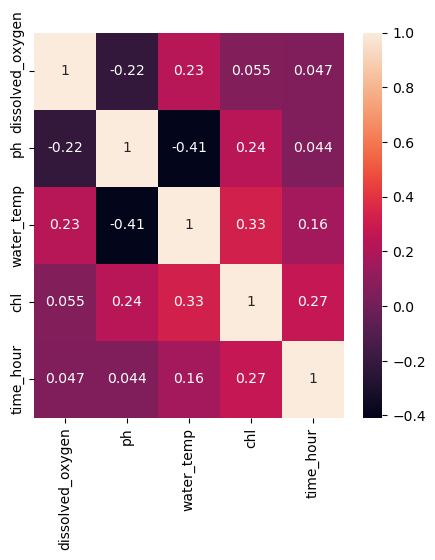

In [182]:
corr = new_df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(
    corr,
    annot=True
)

#### Patterns

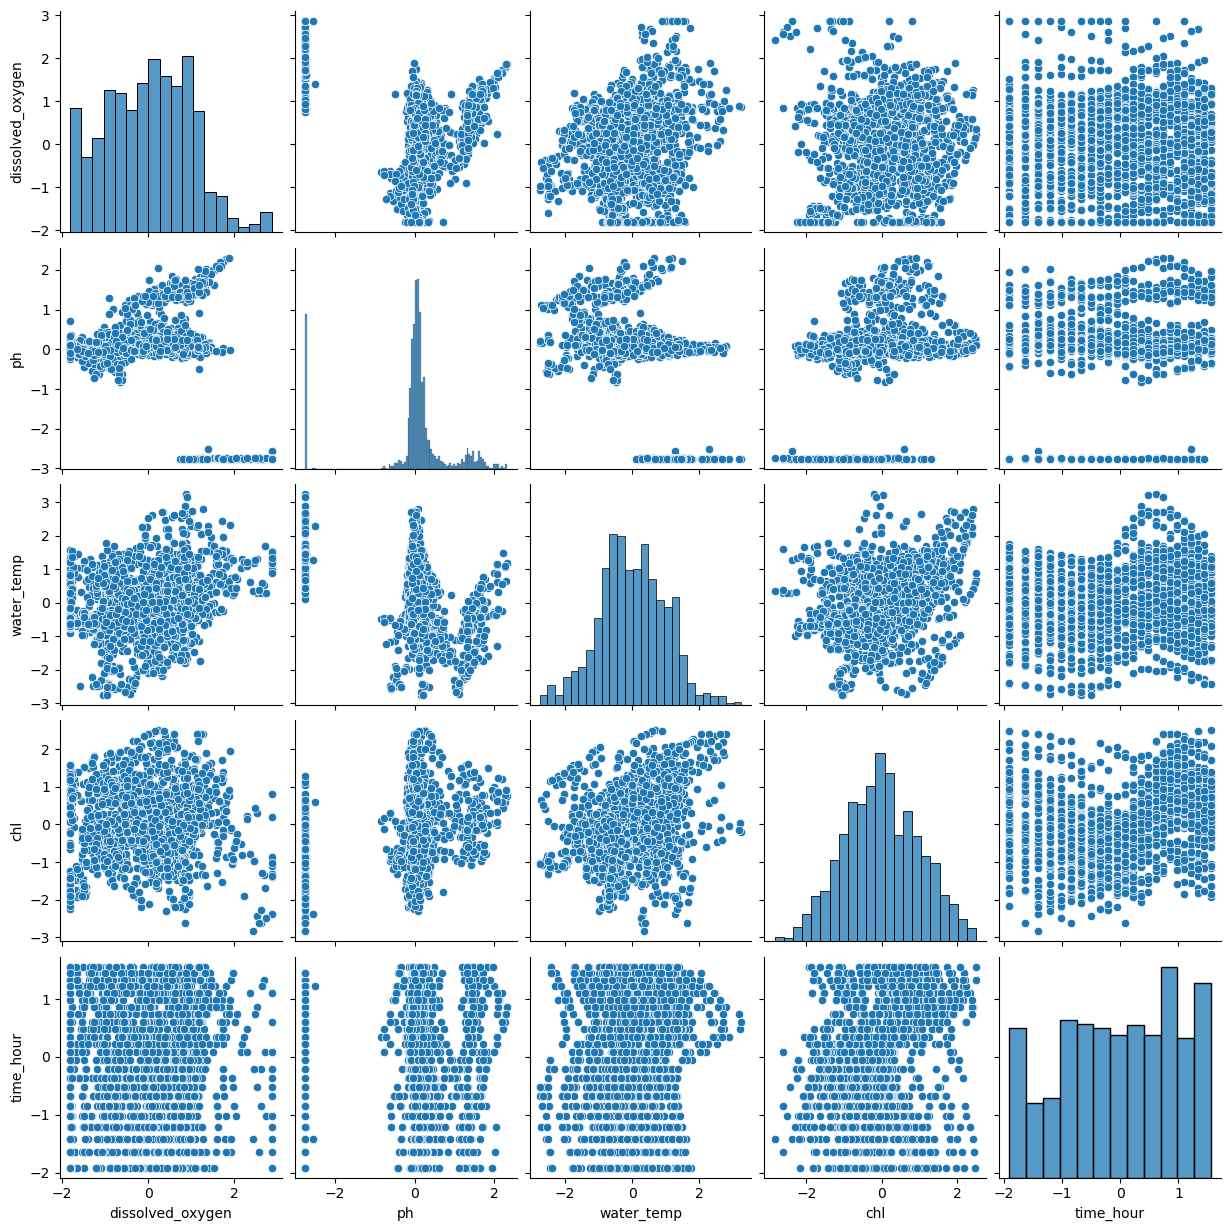

In [ ]:
sns.pairplot(new_df);